# Negative Prompts

Most of this code was written by the fast.ai team. Starting with their code, I did the following:

1. Implemented negative prompts.

2. Combined a few innovations suggested by other fast.ai students for the core diffusion loop:
    
    1. Using the negative prompt where the unconditional prompt would normally go in the diffusion loop. This yields different results because, mathematically, it makes the negative prompt less influential than the positive prompt. It also makes the code much simpler and faster, since it does not need to process any unconditional prompt at all.
    
    2. Normalizing the prediction, stage 1: normalize the entire prediction so its magnitude is always equal to that of the unconditional prediction. This improves the quality of details in the final product. In other words, it creates a slightly sharper image.
    
    3. Normalizing the prediction, stage 2: in addition to stage 1, normalize the magnitude of the guided part of the prediction so its magnitude is equal to that of the unconditional part. This ensures that the guidance amount doesn't fluctuate wildly between diffusion steps, yielding quite different results. I also altered this formula myself so that it works with negative prompts.
    
In the final cells of this notebook, I've compiled the following variations on the formula:
1. The unaltered Stable Diffusion code provided by fast.ai
2. Negative prompts
3. Negative prompts with the algorithm tweak from point 2A in the previous list
4. Normalization stage 1, as described in point 2B in the previous list
5. Normalization stage 2, as described in point 2C in the previous list
6. Grand finale: Negative prompts AND normalization together!

### Imports etc

In [220]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1000)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Added by me
import scipy

# Added from fast.ai but not originally part of this cell
from tqdm.auto import tqdm

## The actual thing

### Some more prep

In [221]:
# 1. The text encoder and tokenizer

from transformers import CLIPTextModel, CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

In [222]:
# 2. The VAE and UNet

from diffusers import AutoencoderKL, UNet2DConditionModel
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [223]:
# 3. The scheduler

beta_start,beta_end = 0.00085,0.012
from diffusers import LMSDiscreteScheduler
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

## THE ACTION, finally.

### The original prompt/setup - the negative prompt comes later

In [224]:
# 4. Parameters for generation

prompt = ["Pine tree"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [225]:
# 5. Tokenize the prompt

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids']

tensor([[49406,  7374,  2677, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [226]:
# 6. Embed the prompt

pos_text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [227]:
# 7. Repeat steps 4-6 for the unconditional prompt and the negative prompt

# Unconditional prompt:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
uncond_embeddings.shape

# Negative prompt:
neg_prompt = ["Forest"]  # This should get us a shot of a pine tree that is not in a forest.
neg_text_input = tokenizer(neg_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
neg_text_embeddings = text_encoder(neg_text_input.input_ids.to("cuda"))[0].half()

In [228]:
# 8. Put the embeddings in the same tensor
# I've created 3 tensors here to accommodate the several variations on the formula

uncond_and_pos_text_embeddings = torch.cat([uncond_embeddings, pos_text_embeddings])
neg_and_pos_text_embeddings = torch.cat([neg_text_embeddings, pos_text_embeddings])
uncond_and_neg_and_pos_text_embeddings = torch.cat([uncond_embeddings, neg_text_embeddings, pos_text_embeddings])

In [229]:
# 9. Initialize the scheduler with the desired number of steps

scheduler.set_timesteps(num_inference_steps)

In [230]:
# 10. Create a permanent store of latents to copy from for each example

# Make the initial latent noise, which is pure Gaussian noise
torch.manual_seed(1000)
permalatents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))
permalatents = permalatents.to("cuda").half()

# Scale the initial noise by the standard deviation required by the scheduler
permalatents = permalatents * scheduler.init_noise_sigma

/tmp/ipykernel_18199/3849602717.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  permalatents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8))


In [231]:
# 11. A display function to call for each permutation of Stable Diffusion I demonstrate

def demo_display(latents):
    # Convert the latents back into an actual photo
    with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)  # Make everything between 0 and 1
    image = image[0].detach().cpu().permute(1, 2, 0).numpy()  # Put it back on CPU and ensure order of dimensions is what Python imaging expects
    image = (image * 255).round().astype("uint8")
    return image

## 12a. Results 1 - unaltered; no negative prompt; no normalization

  0%|          | 0/70 [00:00<?, ?it/s]

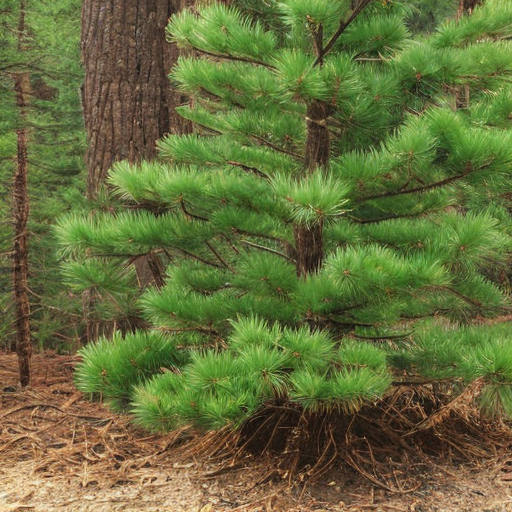

In [232]:
# First, reset the latents
latents = permalatents.detach().clone()


# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 2)  # Concatenate our 2 noise bits together: classifier-free and prompt versions. Note that each bit of noise is now two copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=uncond_and_pos_text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)  # they were concatenated together, and now we pull them apart again
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

## 12b. Results 2 - negative prompt

  0%|          | 0/70 [00:00<?, ?it/s]

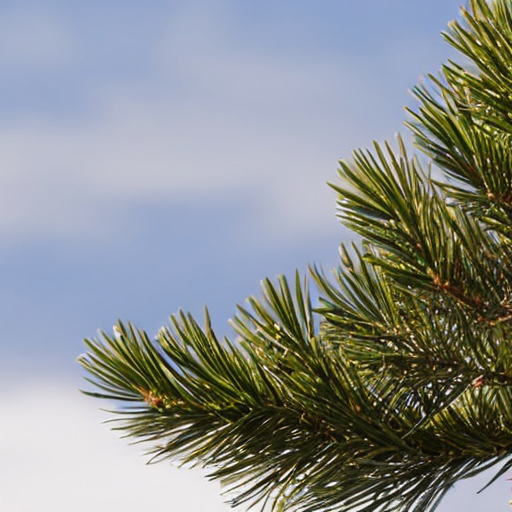

In [233]:
# First, reset the latents
latents = permalatents.detach().clone()

# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 3)  # Concatenate our 3 noise bits together: unconditional and negative prompt and positive prompt versions. Note that each bit of noise is now three copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=uncond_and_neg_and_pos_text_embeddings).sample

    # perform guidance
    pred_uncond, pred_neg, pred_text = pred.chunk(3)  # they were concatenated together, and now we pull them apart again
    pred = pred_uncond + guidance_scale * (pred_text - pred_neg)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

## 12c. Results 3 - negative prompt with alternate, faster algorithm

  0%|          | 0/70 [00:00<?, ?it/s]

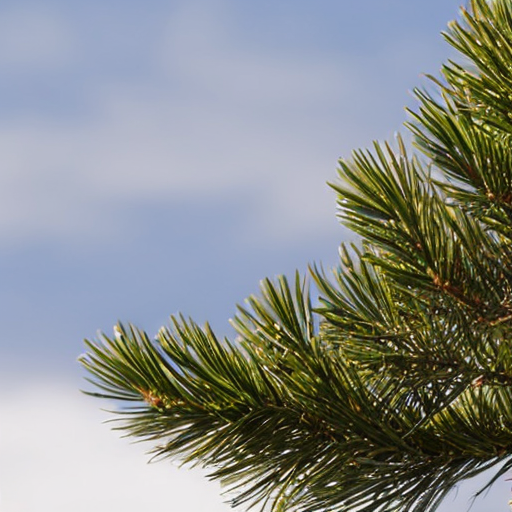

In [234]:
# First, reset the latents
latents = permalatents.detach().clone()


# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 2)  # Concatenate our 2 noise bits together: negative and positive versions. Note that each bit of noise is now two copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=neg_and_pos_text_embeddings).sample

    # perform guidance
    pred_neg, pred_text = pred.chunk(2)  # they were concatenated together, and now we pull them apart again
    pred = pred_neg + guidance_scale * (pred_text - pred_neg)

    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

### Look again: the above image is just slightly different from the previous one from 12b!

## 12d. Results 4 - normalization, stage 1

  0%|          | 0/70 [00:00<?, ?it/s]

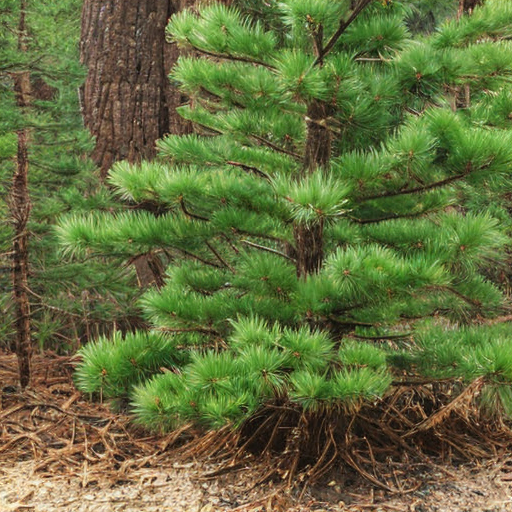

In [235]:
# First, reset the latents
latents = permalatents.detach().clone()


# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 2)  # Concatenate our 2 noise bits together: classifier-free and prompt versions. Note that each bit of noise is now two copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=uncond_and_pos_text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)  # they were concatenated together, and now we pull them apart again
    pred_unscaled = pred_uncond + guidance_scale * (pred_text - pred_uncond)
    pred = pred_unscaled * torch.norm(pred_uncond) / torch.norm(pred_unscaled)  # Normalize the magnitude of each prediction!
    
    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

## 12e. Results 5 - normalization, stage 2

In [236]:
'''
This variant (and the following one) requires a new guidance scale value.

Because the guided term of the prediction is being normalized at each step, its magnitude grows a lot.
So we select a smaller guidance scale value to compensate.
Experimentally, 0.065 seems to do the trick (compared to the old value of 7.5).
This value gets us a more detailed and coherent image of a pine tree in a forest than any image previously generated.
'''

guidance_scale_NORM = 0.065

  0%|          | 0/70 [00:00<?, ?it/s]

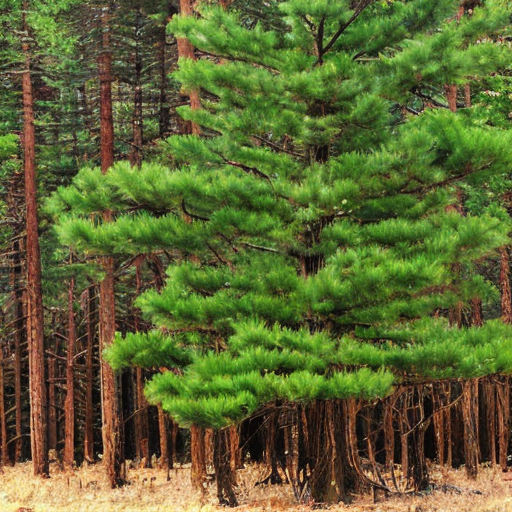

In [237]:
# First, reset the latents
latents = permalatents.detach().clone()


# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 2)  # Concatenate our 2 noise bits together: classifier-free and prompt versions. Note that each bit of noise is now two copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=uncond_and_pos_text_embeddings).sample

    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)  # they were concatenated together, and now we pull them apart again
    pred_unscaled = pred_uncond + guidance_scale_NORM * (pred_text - pred_uncond) / torch.norm(pred_text - pred_uncond) * torch.norm(pred_uncond)
    pred = pred_unscaled * torch.norm(pred_uncond) / torch.norm(pred_unscaled)
    
    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

## 12f. Results 6 - GRAND FINALE: negative prompt AND normalization

  0%|          | 0/70 [00:00<?, ?it/s]

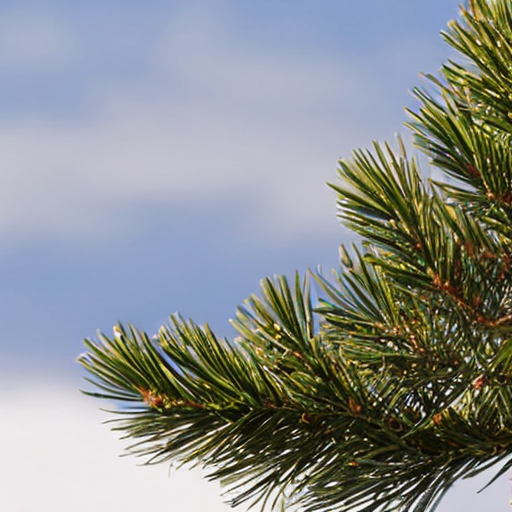

In [238]:
# First, reset the latents
latents = permalatents.detach().clone()


# Run the actual diffusion & display the results

for i, t in enumerate(tqdm(scheduler.timesteps)):  # For each of the 70 timesteps
    input = torch.cat([latents] * 3)  # Concatenate our 3 noise bits together: classifier-free and prompt versions. Note that each bit of noise is now three copies of the same bit of noise, stapled together
    input = scheduler.scale_model_input(input, t)  # Scaling

    # predict the noise residual (i.e. run the UNet)
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=uncond_and_neg_and_pos_text_embeddings).sample

    # perform guidance
    pred_uncond, pred_neg, pred_text = pred.chunk(3)  # they were concatenated together, and now we pull them apart again
    pred_unscaled = pred_uncond + guidance_scale_NORM * (pred_text - pred_neg) / torch.norm(pred_text - pred_neg) * torch.norm(pred_uncond)
    pred = pred_unscaled * torch.norm(pred_uncond) / torch.norm(pred_unscaled)
    
    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

# Convert the latents back into an actual photo
Image.fromarray(demo_display(latents))

Compare the above image to the original negative-prompt image. It's a subtle difference, but this image has slightly clearer details and slightly more vibrant colours. The normalization once again improves overall quality.